### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [70]:
# Imports

import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [71]:
import time

start_time = time.time()
function_times = {}
profiling = False

def measure_time(f):
    def timed(*args, **kw):
        if not profiling:
            return f(*args, **kw)
        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        function_time = te - ts
        
        if f.__name__ not in function_times:
            function_times[f.__name__] = [0, 0]  # [total_time, call_count]
        function_times[f.__name__][0] += function_time
        function_times[f.__name__][1] += 1
        
        return result
    
    return timed

def print_function_times():
    end_time = time.time()
    total_program_time = end_time - start_time
    
    print()
    print("### PROFILING ###")
    print("Total program time: {:.2f} sec".format(total_program_time))
    print("Function times:")
    for function_name, (total_time, call_count) in function_times.items():
        percentage = (total_time / total_program_time) * 100
        average_time = total_time / call_count
        print("- {}: {:.2f} sec ({:.2f}%), {} calls".format(
            function_name, total_time, percentage, call_count, average_time))
    print()

In [72]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


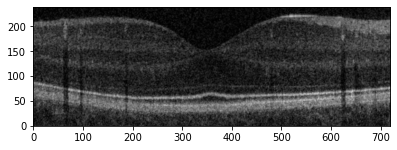

In [73]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [74]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = intermediate_points(self)
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))
    
    @measure_time
    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        height, width = image.shape[:2]
        intermediates[:, 0] = np.clip(intermediates[:, 0], 0, width - 1)
        intermediates[:, 1] = np.clip(intermediates[:, 1], 0, height - 1)
        colours = [image[point[1],point[0]] for point in intermediates] #? had to swap point[1] and point[0] cause y and x were in the other order
        return(np.array(colours)/255)
    @measure_time
    def img_color_across_t(self, t, image):
        # average image colour across all points in t 
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        try:
            return np.array(image[intermediates[:, 1], intermediates[:, 0]]) / 255.0
        except:
            return np.array([0 for _ in range(len(t))])


In [75]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms, alpha=1.0, colour=None):
        colourmap = mpl.colormaps["rainbow"]
        try:
            for worm in worms:
                patch = worm.patch()
                patch.set_alpha(alpha)
                if colour != None:
                    patch.set_edgecolor(colourmap(colour))
                self.ax.add_patch(patch)
        except TypeError:
            patch = worms.patch()
            patch.set_alpha(alpha)
            if colour != None:
                patch.set_edgecolor(colourmap(colour))
            self.ax.add_patch(patch)

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [76]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)


In [77]:
# Initialise a random clew
def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

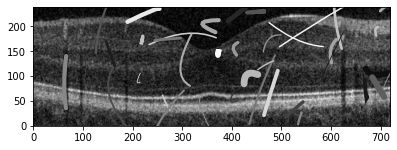

In [78]:
# Initialise clew of 40 and draw
clew = initialise_clew(40, image.shape, (40, 30, 1))
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.show()

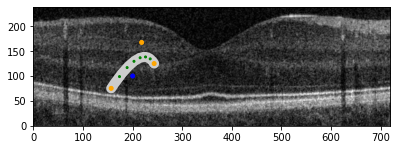

In [79]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/4, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')

drawing.show(save='bezier.png')

In [80]:
# ctrlf
# def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):

In [81]:
class Fitness:
    def __init__(self, image, swarms):
        self.image = image
        self.swarms = swarms
        self.times = {}
        
    @measure_time
    def get(self, worm):
        img_height, img_width = self.image.shape[:2]
        # colour factor
        @measure_time
        def colour():
            DIVISIONS = 4
            t = np.linspace(0,1,DIVISIONS)
            # subtract from 1 since higher fitness is better
            return (1 - np.mean(np.abs(worm.colour - worm.img_color_across_t(t, self.image))),3.5)

        @measure_time
        # width factor
        def width():
            # example weakly encouraging width to be 8
            return (1 / max(abs(worm.width - 5),1),0.3) 

        @measure_time
        # length factor
        def length():
            # provides benefit up to a certin value then no more benefit 
            return (min(worm.r/(img_width/8),1),0.6)

        @measure_time
        # discourage from going out of bounds
        def outside():
            min_x, min_y = np.min(worm.control_points(), axis=0)
            max_x, max_y = np.max(worm.control_points(), axis=0)
            if min_x < 0 or max_x >= img_width or min_y < 0 or max_y >= img_height:
                return (-1, 10)  # high cost for going outside
            else:
                return (0, 0) # doesn't affect worm if it's inside boundaries
        
        @measure_time
        # distance between swarms
        def interswarm():
            SKIPRATE = 10
            # take the first worm instead of the actual average of all worms in that swarm for speed
            avgs = random.sample([s.population[0] for s in swarms], len(swarms)//SKIPRATE)
            distances = [(abs(worm.x - a.x)**2 + abs(worm.y - a.y)**2)**0.5 for a in avgs]
            distances.sort()
            distance = distances[0] # take closest (smallest) distance 
            distance = min(distance, min(img_width, img_height)*2 / np.ceil(len(swarms)**0.5))
            # normalise distance by dividing by the maximum minimum distance between points in a rectangle
            distance /= min(img_width, img_height) / np.ceil(len(swarms)**0.5)
            return (distance, 2)
        
        @measure_time
        # check for crossing worms
        def crossing():
            SKIPRATE = 10
            others = random.sample([s.population[0] for s in swarms], len(swarms)//SKIPRATE)
            for other in others:
                if other == worm:
                    continue
                if worm.path().intersects_path(other.path()):
                    return (-1, 10)
            return (0, 0)
        
        # each factor is a tuple of (fitness, multiplier)
        factors = [colour(), width(), outside(), length(), crossing(), interswarm()]
        return sum([x[0] * x[1] for x in factors])

In [82]:
import random, copy
"""
Each Swarm represents a single worm 
"""
class Swarm:
    def __init__ (self, image, population):
        self.image = image
        self.population = population
        self.fitness = None # must be updated after Fitness class is created
        
        # CONSTANTS #
        
        # number of individuals in the selection tournament
        # a higher tnm_k means it will select more of the best, and less of the worst
        # may converge faster without as much exploration
        self.tnm_k = 3
        
        # rate of mutation which should be between 0 and 1
        # a high rate may prevent convergence, a low rate will need more iterations to converge
        self.m_rate = 0.01 
    @measure_time
    def update(self):
        assert(self.fitness != None)
        fitnesses = [fitness.get(x) for x in self.population]
        new_population = []
        size = len(self.population)
        for i in range(size):
            # tournament selection
            selected_ix = random.randint(0,size-1)
            for ix in [random.randint(0,size-1) for x in range(self.tnm_k-1)]:
                if fitnesses[ix] > fitnesses[selected_ix]:
                    selected_ix = ix
            parent = self.population[selected_ix]
            # mutating
            height, width = image.shape[:2]
            c_x = min(max(parent.x + random.uniform(-self.m_rate*width/2,self.m_rate*width/2),0),width)
            c_y = min(max(parent.y + random.uniform(-self.m_rate*height/2,self.m_rate*height/2),0),height)
            max_r = max(width,height)/2
            c_r = min(max(parent.r + random.uniform(-self.m_rate*max_r/2,self.m_rate*max_r/2),0),max_r)
            c_colour = min(max(parent.colour + random.uniform(-self.m_rate/2,self.m_rate/2),0),1)
            c_theta = (parent.theta + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi)) % (np.pi*2)
            c_dr = min(max(parent.dr + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),-c_r),c_r)
            c_dgamma = min(max(parent.dgamma + random.uniform(-self.m_rate*np.pi,self.m_rate*np.pi),-np.pi),np.pi)
            c_width = min(max(parent.width + random.uniform(-self.m_rate*c_r,self.m_rate*c_r),1),2*c_r)
            # child
            child = Camo_Worm(c_x, c_y, c_r, c_theta, c_dr, c_dgamma, c_width, c_colour)
            new_population.append(child)
        self.population = new_population
    @measure_time
    def avg_worm(self):
        avg = copy.deepcopy(self.population[0])
        for field in ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width']:
            setattr(avg, field, np.mean([getattr(w, field) for w in self.population]))
        return avg
    

Iteration: 100
Time Remaining: 618 seconds
Fitness: [5.21, 4.66, 4.78, 5.56, 5.68, 5.67, 5.09, 6.31, 5.31, 5.87, 4.74, 4.89, 6.07, 5.88, 5.9, 6.01, 4.51, 6.64, 5.03, 4.7, 4.7, 5.99, 5.34, 7.01, 5.77, 6.04, 5.77, 5.65, 2.01, 6.23, 5.73, 5.13]
Mutation Rate: 0.0397
Tournament Size: 2

### PROFILING ###
Total program time: 68.68 sec
Function times:
- img_color_across_t: 12.62 sec (18.38%), 103424 calls
- colour: 25.24 sec (36.76%), 103424 calls
- width: 0.44 sec (0.63%), 103424 calls
- outside: 5.27 sec (7.67%), 103424 calls
- length: 0.37 sec (0.54%), 103424 calls
- crossing: 19.07 sec (27.77%), 103424 calls
- interswarm: 5.66 sec (8.25%), 103424 calls
- get: 59.18 sec (86.16%), 103424 calls
- update: 67.88 sec (98.84%), 3200 calls



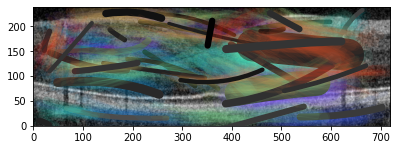


Iteration: 200
Time Remaining: 543 seconds
Fitness: [5.32, 6.46, 4.57, 4.63, 6.51, 4.25, 7.3, 6.29, 4.61, 5.85, 4.88, 6.24, 5.38, 4.97, 4.71, 5.11, 4.75, 5.09, 5.69, 5.26, 5.27, 6.82, 4.89, 6.78, 6.52, 3.5, 4.09, 5.57, 5.47, 5.37, 4.86, 5.07]
Mutation Rate: 0.032
Tournament Size: 2

### PROFILING ###
Total program time: 135.99 sec
Function times:
- img_color_across_t: 24.21 sec (17.80%), 206848 calls
- colour: 48.44 sec (35.62%), 206848 calls
- width: 0.83 sec (0.61%), 206848 calls
- outside: 10.03 sec (7.37%), 206848 calls
- length: 0.70 sec (0.52%), 206848 calls
- crossing: 36.54 sec (26.87%), 206848 calls
- interswarm: 10.86 sec (7.99%), 206848 calls
- get: 113.45 sec (83.42%), 206848 calls
- update: 130.03 sec (95.62%), 6400 calls
- avg_worm: 0.01 sec (0.01%), 32 calls



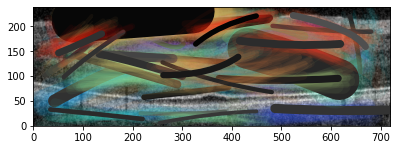


Iteration: 300
Time Remaining: 475 seconds
Fitness: [5.26, 4.65, 6.68, 5.04, 6.34, 4.44, 5.06, 6.07, 6.16, 5.47, 5.38, 3.71, 6.57, 6.57, 4.84, 6.11, 5.6, 4.96, 6.31, 5.51, 5.6, 4.0, 5.79, 4.8, 6.21, 5.52, 5.7, 5.58, 5.92, 5.98, 5.08, 4.78]
Mutation Rate: 0.0263
Tournament Size: 3

### PROFILING ###
Total program time: 203.79 sec
Function times:
- img_color_across_t: 35.95 sec (17.64%), 310272 calls
- colour: 72.01 sec (35.33%), 310272 calls
- width: 1.27 sec (0.62%), 310272 calls
- outside: 14.90 sec (7.31%), 310272 calls
- length: 1.06 sec (0.52%), 310272 calls
- crossing: 54.51 sec (26.75%), 310272 calls
- interswarm: 16.06 sec (7.88%), 310272 calls
- get: 168.79 sec (82.82%), 310272 calls
- update: 193.59 sec (94.99%), 9600 calls
- avg_worm: 0.03 sec (0.01%), 64 calls



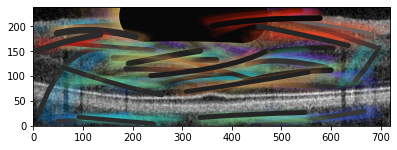


Iteration: 400
Time Remaining: 399 seconds
Fitness: [5.44, 5.15, 6.49, 5.37, 6.69, 6.17, 7.32, 5.97, 6.53, 5.14, 5.39, 5.54, 5.97, 4.76, 4.91, 5.51, 4.63, 4.63, 5.76, 5.51, 5.92, 3.63, 5.51, 4.01, 5.07, 6.2, 4.96, 4.89, 5.48, 5.97, 2.88, 4.29]
Mutation Rate: 0.0221
Tournament Size: 4

### PROFILING ###
Total program time: 266.20 sec
Function times:
- img_color_across_t: 46.79 sec (17.58%), 413696 calls
- colour: 93.60 sec (35.16%), 413696 calls
- width: 1.65 sec (0.62%), 413696 calls
- outside: 19.30 sec (7.25%), 413696 calls
- length: 1.38 sec (0.52%), 413696 calls
- crossing: 70.90 sec (26.63%), 413696 calls
- interswarm: 20.96 sec (7.88%), 413696 calls
- get: 219.44 sec (82.43%), 413696 calls
- update: 251.78 sec (94.58%), 12800 calls
- avg_worm: 0.04 sec (0.02%), 96 calls



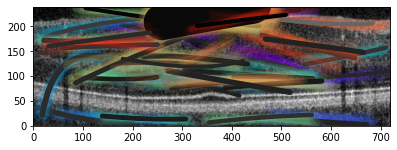


Iteration: 500
Time Remaining: 333 seconds
Fitness: [4.44, 6.01, 5.86, 5.61, 4.1, 5.08, 6.77, 4.09, 6.78, 5.24, 5.76, 6.87, 5.33, 4.59, 5.4, 5.08, 5.95, 6.65, 4.69, 5.02, 6.72, 3.86, 4.68, 7.25, 4.37, 5.15, 4.81, 6.42, 7.34, 6.46, 7.55, 5.74]
Mutation Rate: 0.019
Tournament Size: 6

### PROFILING ###
Total program time: 333.09 sec
Function times:
- img_color_across_t: 58.21 sec (17.47%), 517120 calls
- colour: 116.40 sec (34.95%), 517120 calls
- width: 2.06 sec (0.62%), 517120 calls
- outside: 24.05 sec (7.22%), 517120 calls
- length: 1.73 sec (0.52%), 517120 calls
- crossing: 88.54 sec (26.58%), 517120 calls
- interswarm: 26.15 sec (7.85%), 517120 calls
- get: 273.44 sec (82.09%), 517120 calls
- update: 314.31 sec (94.36%), 16000 calls
- avg_worm: 0.05 sec (0.02%), 128 calls



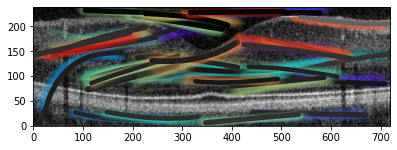


Iteration: 600
Time Remaining: 266 seconds
Fitness: [6.13, 5.93, 6.24, 6.47, 6.85, 5.67, 6.89, 7.56, 6.18, 6.41, 6.66, 5.02, 6.85, 5.03, 4.63, 4.16, 6.42, 5.24, 6.63, 6.77, 5.68, 5.87, 7.01, 6.41, 3.87, 5.59, 6.18, 4.61, 7.32, 6.13, 5.8, 4.53]
Mutation Rate: 0.0166
Tournament Size: 9

### PROFILING ###
Total program time: 399.42 sec
Function times:
- img_color_across_t: 69.39 sec (17.37%), 620544 calls
- colour: 138.89 sec (34.77%), 620544 calls
- width: 2.45 sec (0.61%), 620544 calls
- outside: 28.75 sec (7.20%), 620544 calls
- length: 2.07 sec (0.52%), 620544 calls
- crossing: 105.76 sec (26.48%), 620544 calls
- interswarm: 31.25 sec (7.82%), 620544 calls
- get: 326.51 sec (81.75%), 620544 calls
- update: 376.33 sec (94.22%), 19200 calls
- avg_worm: 0.07 sec (0.02%), 160 calls



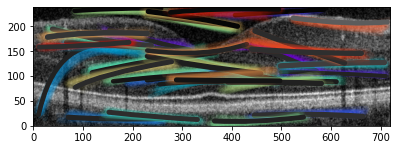


Iteration: 700
Time Remaining: 202 seconds
Fitness: [4.42, 4.44, 5.44, 6.16, 6.95, 3.23, 6.41, 6.39, 5.65, 6.13, 5.9, 4.27, 6.24, 5.78, 6.53, 4.98, 4.9, 7.53, 6.68, 5.4, 6.17, 3.92, 7.12, 6.03, 5.99, 3.9, 5.65, 5.49, 5.94, 5.49, 5.42, 3.15]
Mutation Rate: 0.0149
Tournament Size: 13

### PROFILING ###
Total program time: 471.81 sec
Function times:
- img_color_across_t: 81.62 sec (17.30%), 723968 calls
- colour: 163.34 sec (34.62%), 723968 calls
- width: 2.88 sec (0.61%), 723968 calls
- outside: 33.84 sec (7.17%), 723968 calls
- length: 2.44 sec (0.52%), 723968 calls
- crossing: 124.46 sec (26.38%), 723968 calls
- interswarm: 36.75 sec (7.79%), 723968 calls
- get: 384.11 sec (81.41%), 723968 calls
- update: 444.07 sec (94.12%), 22400 calls
- avg_worm: 0.08 sec (0.02%), 192 calls



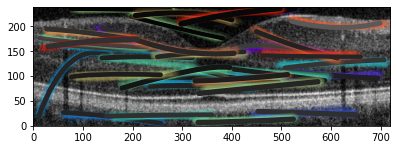


Iteration: 800
Time Remaining: 135 seconds
Fitness: [5.36, 5.63, 6.86, 5.24, 6.85, 5.7, 5.26, 7.74, 6.65, 5.97, 4.81, 4.75, 6.15, 4.79, 6.67, 3.5, 5.61, 6.19, 5.47, 5.22, 5.27, 5.98, 6.49, 3.62, 3.37, 4.86, 3.79, 5.22, 7.03, 5.11, 5.82, 3.82]
Mutation Rate: 0.0136
Tournament Size: 16

### PROFILING ###
Total program time: 542.11 sec
Function times:
- img_color_across_t: 93.40 sec (17.23%), 827392 calls
- colour: 186.85 sec (34.47%), 827392 calls
- width: 3.28 sec (0.60%), 827392 calls
- outside: 38.82 sec (7.16%), 827392 calls
- length: 2.79 sec (0.51%), 827392 calls
- crossing: 142.42 sec (26.27%), 827392 calls
- interswarm: 42.13 sec (7.77%), 827392 calls
- get: 439.57 sec (81.09%), 827392 calls
- update: 510.13 sec (94.10%), 25600 calls
- avg_worm: 0.10 sec (0.02%), 224 calls



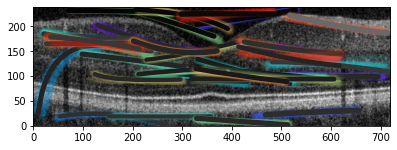


Iteration: 900
Time Remaining: 67 seconds
Fitness: [4.96, 7.29, 6.95, 4.07, 7.03, 5.16, 5.0, 7.28, 6.18, 5.41, 7.52, 4.8, 6.27, 6.46, 6.54, 3.17, 5.17, 4.68, 5.8, 6.34, 4.39, 6.45, 7.27, 5.39, 5.66, 4.34, 6.67, 6.26, 6.65, 5.12, 4.99, 4.76]
Mutation Rate: 0.0127
Tournament Size: 20

### PROFILING ###
Total program time: 611.84 sec
Function times:
- img_color_across_t: 104.83 sec (17.13%), 930816 calls
- colour: 209.69 sec (34.27%), 930816 calls
- width: 3.66 sec (0.60%), 930816 calls
- outside: 43.60 sec (7.13%), 930816 calls
- length: 3.11 sec (0.51%), 930816 calls
- crossing: 159.86 sec (26.13%), 930816 calls
- interswarm: 47.28 sec (7.73%), 930816 calls
- get: 493.32 sec (80.63%), 930816 calls
- update: 575.03 sec (93.98%), 28800 calls
- avg_worm: 0.12 sec (0.02%), 256 calls



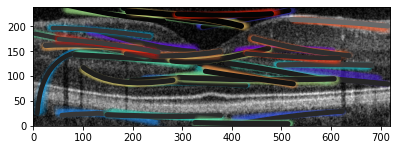


Iteration: 1000
Time Remaining: 0 seconds
Fitness: [6.5, 5.86, 5.85, 5.71, 7.18, 6.01, 6.37, 6.22, 5.72, 6.13, 6.63, 4.2, 6.4, 5.74, 6.91, 4.66, 6.01, 6.7, 6.92, 5.07, 5.4, 6.95, 6.9, 4.94, 5.41, 4.19, 7.2, 6.96, 6.93, 5.04, 6.19, 5.81]
Mutation Rate: 0.012
Tournament Size: 24

### PROFILING ###
Total program time: 684.39 sec
Function times:
- img_color_across_t: 116.49 sec (17.02%), 1034240 calls
- colour: 233.19 sec (34.07%), 1034240 calls
- width: 4.06 sec (0.59%), 1034240 calls
- outside: 48.53 sec (7.09%), 1034240 calls
- length: 3.45 sec (0.50%), 1034240 calls
- crossing: 178.23 sec (26.04%), 1034240 calls
- interswarm: 52.67 sec (7.70%), 1034240 calls
- get: 549.21 sec (80.25%), 1034240 calls
- update: 643.18 sec (93.98%), 32000 calls
- avg_worm: 0.13 sec (0.02%), 288 calls



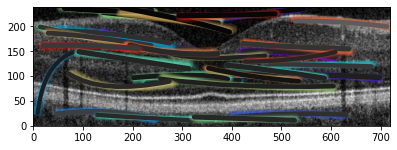

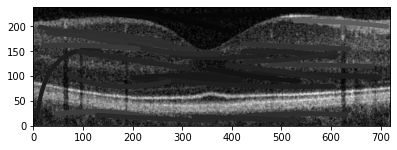

In [87]:
# for profiling
start_time = time.time()
function_times = {}
profiling = True # change to True to see function times
# constants
iterations = 1000
swarm_size = 32
num_swarms = 32
swarms = [Swarm(image, initialise_clew(swarm_size, image.shape, (40, 30, 1))) for _ in range(num_swarms)]
fitness = Fitness(image, swarms)
for s in swarms:
    s.fitness = fitness
    #s.tnm_k = 4
    #s.m_rate = 0.02

for it in range(iterations):
    fitnesses = []
    for swarm in swarms:
        # start the mutation rate high for a short time then keep it low for a long time (exponential)
        # allows for fast exploration at the start with fine tuning of the final solution at the end
        swarm.m_rate = 0.04 * np.exp(-3 * (it / iterations)) + 0.01 # -3 growth rate so it quickly decreases
        # same principle with tournament size, except that it starts low and increases over time
        # if tournament size = population, all children will come from the best parent (no diversity)
        swarm.tnm_k = max(int(len(swarm.population) / (1+np.exp(-5 * (it/iterations-0.8)))+1), 2) 
        swarm.update()
    if (it+1) % (iterations//10) == 0:
        all_fitnesses = [sum(x) / len(x) for x in [[fitness.get(w) for w in p.population] for p in swarms]]
        print("Iteration:",it+1)
        print("Time Remaining:",int((time.time() - start_time) / (it+1) * (iterations - (it+1))),"seconds")
        print("Fitness:",[float(f"{x:.3}") for x in all_fitnesses])
        print(f"Mutation Rate: {swarms[0].m_rate:.3}")
        print(f"Tournament Size: {swarms[0].tnm_k}")
        if profiling:
            print_function_times()
        drawing = Drawing(image)
        for ix in range(len(swarms)):
            drawing.add_worms(swarms[ix].population, alpha=0.05, colour=(ix/len(swarms)))
            drawing.add_worms(swarms[ix].avg_worm())
        drawing.show()
        print()
drawing = Drawing(image)
for ix in range(len(swarms)):
    drawing.add_worms(swarms[ix].avg_worm())
drawing.show()
    